In [114]:
# TODO: create another dictionary with nd2 average fluorescence; extract it for each session.
# TODO: save the extracted data in a h5 file or something similar. Do session extraction for whole dataset

In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [191]:
import labrotation.file_handling as fh
import h5py
from time import time
import matplotlib.pyplot as plt
import numpy as np
import os
from labrotation import file_handling as fh
from copy import deepcopy
import pandas as pd
import labrotation.two_photon_session as tps
import seaborn as sns
import uuid  # for unique labeling of sessions and coupling arrays (mouse velocity, distance, ...) to sessions in dataframe 
from matplotlib import cm  # colormap

In [3]:
# assumption: inside the documentation folder, the subfolders carry the id of each mouse (not exact necessarily, but they 
# can be identified by the name of the subfolder). 
# Inside the subfolder xy (for mouse xy), xy_grouping.xlsx and xy_segmentation.xlsx can be found.
# xy_grouping.xlsx serves the purpose of finding the recordings belonging together, and has columns:
# folder, nd2, labview, lfp, face_cam_last, nikon_meta, experiment_type, day
# xy_segmentation.xlsx contains frame-by-frame (given by a set of disjoint intervals forming a cover for the whole recording) 
# classification of the events in the recording ("normal", seizure ("sz"), sd wave ("sd_wave") etc.). The columns:
# folder, interval_type, frame_begin, frame_end.

# TODO: write documentation on contents of xlsx files (what the columns are etc.)
docu_folder = fh.open_dir("Choose folder containing folders for each mouse!")
print(f"Selected folder:\n\t{docu_folder}")

Selected folder:
	D:\Data documentation\documentation


In [4]:
mouse_folders = os.listdir(docu_folder)
print(f"Mice detected:")
for mouse in mouse_folders:
    print(f"\t{mouse}")

Mice detected:
	T301
	T303
	T324
	T329
	T333
	T337
	T370
	T386
	T391
	T396
	T452
	T534


In [5]:
matlab_2p_folder = fh.open_dir("Choose matlab-2p folder")

In [6]:
df_seg_complete = pd.DataFrame(columns = ["nd2", "interval_type", "frame_begin", "frame_end"])
df_grouping_complete = pd.DataFrame(columns = ["folder", "nd2", "labview", "lfp", "face_cam_last", "nikon_meta", "experiment_type", "mouse_id", "day"])

for mouse_id in mouse_folders:
    print(mouse_id)
    seg_fpath = os.path.join(docu_folder, mouse_id, mouse_id + '_segmentation.xlsx')
    grouping_fpath = os.path.join(docu_folder, mouse_id, mouse_id + '_grouping.xlsx')
    if os.path.exists(seg_fpath) and os.path.exists(grouping_fpath):
        df_seg = pd.read_excel(seg_fpath)
        df_grouping = pd.read_excel(grouping_fpath)
        df_grouping["mouse_id"] = mouse_id
        # select only tmev, chr2_szsd, chr2_sd, chr2_ctl experiment data first
        df_grouping = df_grouping[df_grouping["experiment_type"].isin(["tmev", "tmev_ctl", "chr2_sd", "chr2_szsd", "chr2_ctl"])]
        # merge into large dataframes
        print(f"\tseg bef: {len(df_seg_complete['nd2'])}")
        df_seg_complete = pd.concat([df_seg_complete, df_seg])
        print(f"\tseg aft: {len(df_seg_complete['nd2'])}")
        print(f"\tgro bef: {len(df_grouping_complete['nd2'])}")
        df_grouping_complete = pd.concat([df_grouping_complete, df_grouping])
        print(f"\tgro aft: {len(df_grouping_complete['nd2'])}")
    else:
        print(f"Check if you set the correct folder (folder containing all subfolders with mouse names):")
        if not os.path.exists(seg_fpath):
            print(f"\t{seg_fpath} not found")
        if not os.path.exists(grouping_fpath):
            print(f"\t{grouping_fpath} not found")
        

T301
	seg bef: 0
	seg aft: 27
	gro bef: 0
	gro aft: 64
T303
	seg bef: 27
	seg aft: 67
	gro bef: 64
	gro aft: 107
T324
	seg bef: 67
	seg aft: 105
	gro bef: 107
	gro aft: 141
T329
	seg bef: 105
	seg aft: 121
	gro bef: 141
	gro aft: 149
T333
	seg bef: 121
	seg aft: 311
	gro bef: 149
	gro aft: 201
T337
	seg bef: 311
	seg aft: 348
	gro bef: 201
	gro aft: 238
T370
	seg bef: 348
	seg aft: 554
	gro bef: 238
	gro aft: 284
T386
	seg bef: 554
	seg aft: 611
	gro bef: 284
	gro aft: 298
T391
	seg bef: 611
	seg aft: 625
	gro bef: 298
	gro aft: 308
T396
	seg bef: 625
	seg aft: 638
	gro bef: 308
	gro aft: 324
T452
	seg bef: 638
	seg aft: 696
	gro bef: 324
	gro aft: 338
T534
	seg bef: 696
	seg aft: 705
	gro bef: 338
	gro aft: 344


In [15]:
# take only recordings that were classified as "tmev" (experiment type)
df_seg_complete.where(df_seg_complete["nd2"].isin(df_grouping_complete["nd2"].unique()), inplace=True)
# wrong recording types changed to NaN; drop them
df_seg_complete.dropna(inplace=True)

In [16]:
# need to create new dataframe. 
# x axis will be: baseline, seizure, sd_wave, sd_extinction, aftermath...
# one plot: only with seizures 
#   (check categories: chr2_sz/chr2_szsd? tmev_sz? check interval types corresponding to seizure, sd etc.)
# other plot: chr2 only?

# Baseline - Seizure - SD - aftermath analysis 

In [17]:
# take only videos with seizure
df_sz = df_seg_complete.groupby("nd2").filter(lambda group: "sz" in group["interval_type"].unique())

In [18]:
len(df_sz)

139

# TODO: some recordings start with non-"normal" event type! How to deal with these? E.g. fake-handling!
# TODO: test if _nik.txt is read correctly for stimulations (where first column has weird format)!

In [19]:
# change labels of segments that start the video until seizure as "baseline"
df_sz.loc[(df_sz["interval_type"] == "normal") & (df_sz["frame_begin"] == 1.0), "interval_type"] = "baseline"
# assuming one seizure per video, and that there is no "normal" labeling between "abnormal" events like SZ and SD, 
#   change label to aftermath
# TODO: change this to frame_end == len(recording)? i.e. last part in video?
df_sz.loc[(df_sz["interval_type"] == "normal") & (df_sz["frame_begin"] != 1.0), "interval_type"] = "aftermath"  # second criterion is not even necessary anymore...

In [20]:
# TODO: some recordings have iis between "normal". Change them to normal to include them in movement statistics.

In [21]:
len(df_grouping_complete["nd2"]) == len(df_grouping_complete["nd2"].unique())  # grouping should be unique!

True

In [22]:
sz_vids = df_sz["nd2"].unique()
df_sz_grouping = df_grouping_complete[df_grouping_complete["nd2"].isin(sz_vids)]

In [23]:
len(df_sz_grouping["nd2"]) == len(df_sz_grouping["nd2"].unique())

True

In [24]:
df_sz_grouping.keys()

Index(['folder', 'nd2', 'labview', 'lfp', 'face_cam_last', 'nikon_meta',
       'experiment_type', 'mouse_id', 'day'],
      dtype='object')

In [25]:
# TODO: rename row to row_grouping, row2 to row_segment

sz_nd2s = list()  # should contain nd2 file names for backtracking
sz_segments_speed_dict = dict()
sz_segments_dist_dict = dict()
sz_segments_totdist_dict = dict()
sz_segments_rounds_dict = dict()
sz_segments_tsscn_dict = dict()
sz_segments_running_dict = dict()

df_sz_res_cols = {"mouse_id": [], "experiment_type": [], "interval_type": [], "distance": [], "d_frames": [], "dt": []}

# for each recording in category, create session, 
# perform labview cut to scanner timeframe, 
# then extract relevant frame movement data
# results appended to segments_dict entries.
# segments_dict should contain, for each key (type of interval) all the corresponding data from all videos
for index, row in df_sz_grouping.iterrows():
    labview_fpath = os.path.join(row["folder"], row["labview"])
    nikmeta_fpath = os.path.join(row["folder"], row["nikon_meta"])
    
    ses = tps.TwoPhotonSession(nd2_timestamps_path=nikmeta_fpath, labview_path=labview_fpath, matlab_2p_folder=matlab_2p_folder)
    ses.infer_labview_timestamps()
    ses._open_data()  # TODO: implement a better way than using "private" function
    ses_segments = df_sz[df_sz["nd2"]==row["nd2"]]  # get all segments from the same file
    for index2, row2 in ses_segments.iterrows():
        t0 = int(row2["frame_begin"] - 1)  # correct 1-indexing to 0-indexing, convert to int
        t1 = int(row2["frame_end"])  # list[a:b] returns elements a to (b-1), so no need to subtract here
        
        # Check if dictionary entries exist
        if row2["interval_type"] not in sz_segments_speed_dict.keys():
            sz_segments_speed_dict[row2["interval_type"]] = []
        if row2["interval_type"] not in sz_segments_dist_dict.keys():   
            sz_segments_dist_dict[row2["interval_type"]] = []
        if row2["interval_type"] not in sz_segments_totdist_dict.keys():     
            sz_segments_totdist_dict[row2["interval_type"]] = []
        if row2["interval_type"] not in sz_segments_rounds_dict.keys():    
            sz_segments_rounds_dict[row2["interval_type"]] = []
        if row2["interval_type"] not in sz_segments_tsscn_dict.keys():    
            sz_segments_tsscn_dict[row2["interval_type"]] = []
        if row2["interval_type"] not in sz_segments_running_dict.keys():    
            sz_segments_running_dict[row2["interval_type"]] = []
        
        # append to dictionaries and nd2 list
        sz_nd2s.append(row["nd2"])
        sz_segments_speed_dict[row2["interval_type"]].append(deepcopy(ses.belt_scn_dict["speed"][t0:t1]))
        sz_segments_dist_dict[row2["interval_type"]].append(deepcopy(ses.belt_scn_dict["distance"][t0:t1]))
        sz_segments_totdist_dict[row2["interval_type"]].append(deepcopy(ses.belt_scn_dict["totdist"][t0:t1]))
        sz_segments_rounds_dict[row2["interval_type"]].append(deepcopy(ses.belt_scn_dict["rounds"][t0:t1]))
        sz_segments_tsscn_dict[row2["interval_type"]].append(deepcopy(ses.belt_scn_dict["tsscn"][t0:t1]))
        sz_segments_running_dict[row2["interval_type"]].append(deepcopy(ses.belt_scn_dict["running"][t0:t1]))
        
        # append to dataframe columns
        df_sz_res_cols["mouse_id"].append(row["mouse_id"])
        df_sz_res_cols["experiment_type"].append(row["experiment_type"])
        df_sz_res_cols["interval_type"].append(row2["interval_type"])
        df_sz_res_cols["distance"].append(ses.belt_scn_dict["totdist"][t1-1] - ses.belt_scn_dict["totdist"][t0])  # t1 is 1-indexed, t0 0-indexed, see above
        df_sz_res_cols["d_frames"].append(t1 - 1 - t0)  # t1 is 1-indexed, t0 0-indexed, see above
        # dt: in ms
        df_sz_res_cols["dt"].append(ses.belt_scn_dict["tsscn"][t1-1] - ses.belt_scn_dict["tsscn"][t0]) # t1 is 1-indexed, t0 0-indexed, see above

Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\tmev\T301\T301_tmev_d1\T301_tmev_d1.270820.1151time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\tmev\T301\T301_tmev_d1
	T301_tmev_d1.270820.1151
	T301_tmev_d1.270820.1151_nik
No conversion of belt_length_mm happened, as belt_params['belt_length_mm'] is type <class 'float'>
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\tmev\T301\T301_tmev_d1\T301_tmev_d1.270820.1209time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\tmev\T301\T301_tmev_d1
	T301_tmev_d1.270820.1209
	T301_tmev_d1.270820.1209_nik
No conversion of belt_length_mm happened, as belt_params['belt_length_mm'] is type <class 'float'>
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\tmev\T301\T301_tmev_d1\T301_tmev_d1.270820.1228time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\tmev\T301\T301_tmev_d1
	T301_tmev_d1.270820.1228
	T30

Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\tmev\T396-1\T396-1_tmev_d3
	T396-1_tmev_d3.260621.1439
	T396-1_tmev_d3.260621.1439_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\tmev\T534\T534_tmev_d2_extra\T534_tmev_d2_extra.170822.2225time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\tmev\T534\T534_tmev_d2_extra
	T534_tmev_d2_extra.170822.2225
	T534_tmev_d2_extra.170822.2225_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\tmev\T534\T534_tmev_d2_extra\T534_tmev_d2_extra.170822.2306time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\tmev\T534\T534_tmev_d2_extra
	T534_tmev_d2_extra.170822.2306
	T534_tmev_d2_extra.170822.2306_nik


In [26]:
# create df from dict:
df_sz_res = pd.DataFrame.from_dict(df_sz_res_cols)

In [27]:
# normalize distance by the interval length 
# also take absolute value; especially during shorter intervals, mice might step backwards a few times and that's it 
df_sz_res["dist_norm"] = abs(df_sz_res["distance"]/df_sz_res["dt"])  

In [28]:
df_sz_res.head()

,mouse_id,experiment_type,interval_type,distance,d_frames,dt,dist_norm
0,T301,tmev,baseline,0.000000,8671,569180.56995,0.000000
1,T301,tmev,sz,17.000000,474,31114.67680,0.000546
2,T301,tmev,sd_wave,349.000000,153,10043.35400,0.034749
3,T301,tmev,sd_extinction,1374.414634,1005,65971.16370,0.020834
4,T301,tmev,aftermath,6632.585366,6177,405480.67380,0.016357


In [29]:
df_sz_res["mouse_id"].unique()

array(['T301', 'T329', 'T333', ..., 'T391', 'T396', 'T534'], dtype=object)

In [30]:
# todo work with dataframe, seaborn plot. if fine, use chr2 too (ctl stim vs szsd, vs sd only. need more sd only?)

In [31]:
# 3. open 2psession for each nd2, do matching. Need nd2? or only nd2 meta + labview. Latter would be much quicker.

In [32]:
# TODO: create df from results! With ID, exp type, interval type...
# TODO: visualize data somehow. Take code from below (Unorganized)!

In [33]:
# result dataframe could be:
# ID, interval_type, distance, dt, distance_norm

In [34]:
df_sz_res["interval_type"].unique()

array(['baseline', 'sz', 'sd_wave', ..., 'iis', 'stimulation',
       'sd_wave_cx'], dtype=object)

In [35]:
df_sz_res["experiment_type"].unique()

array(['tmev', 'chr2_szsd'], dtype=object)

In [36]:
# TODO: convert iis to normal for the sake of locomotion analysis?
# TODO: add more recordings with seizures. Don't need complete tmev groupings for now... Only videos with seizures.

In [37]:
df_sz_res["interval_type_renamed"] = df_sz_res["interval_type"].replace({"sd_wave_cx": "sd_wave"})
df_sz_res["experiment_type_renamed"] = df_sz_res["experiment_type"].replace({"tmev": "TMEV", "chr2_szsd": "ChR2"})

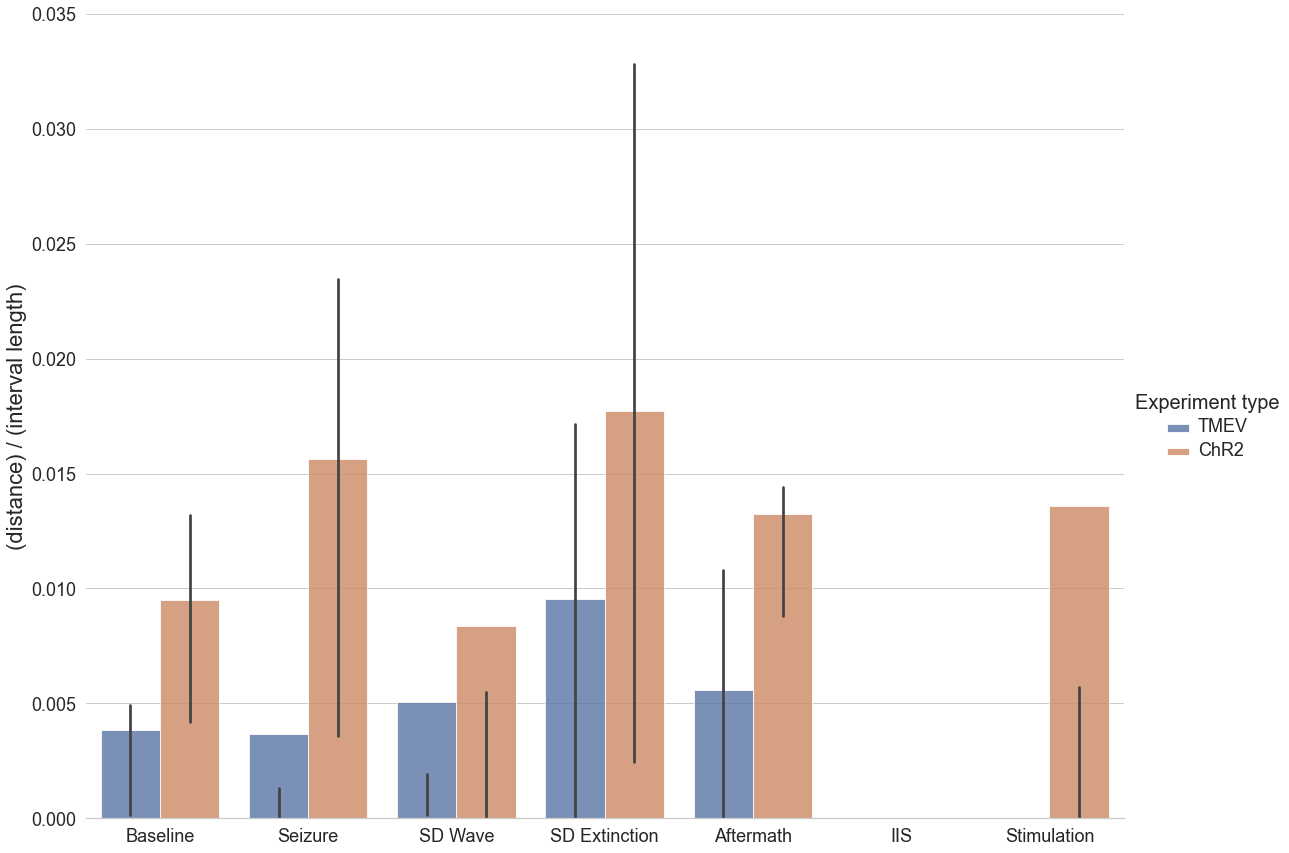

In [38]:
sns.set_theme(style="whitegrid")
#sns.set(rc={'figure.figsize':(20.7,8.27)})

# use standard error or standard deviation for uncertainty/spread, or confidence interval or percentile interval
# se/sd/ci/pi
# see https://seaborn.pydata.org/tutorial/error_bars.html
g = sns.catplot(
    data=df_sz_res, kind="bar",
    x="interval_type_renamed", y="dist_norm", hue="experiment_type_renamed",
    errorbar=("pi", 50), alpha=.8, height=12, aspect=1.3
);
g.despine(left=True)
g.set_axis_labels("", "(distance) / (interval length)", fontsize=22)
g.set_xticklabels(["Baseline", "Seizure", "SD Wave", "SD Extinction", "Aftermath", "IIS", "Stimulation"], fontsize=18)
g.set_yticklabels(fontsize=18)
g._legend.set_title("Experiment type")
plt.setp(g._legend.get_title(), fontsize=20);
plt.setp(g._legend.get_texts(),  fontsize=18);

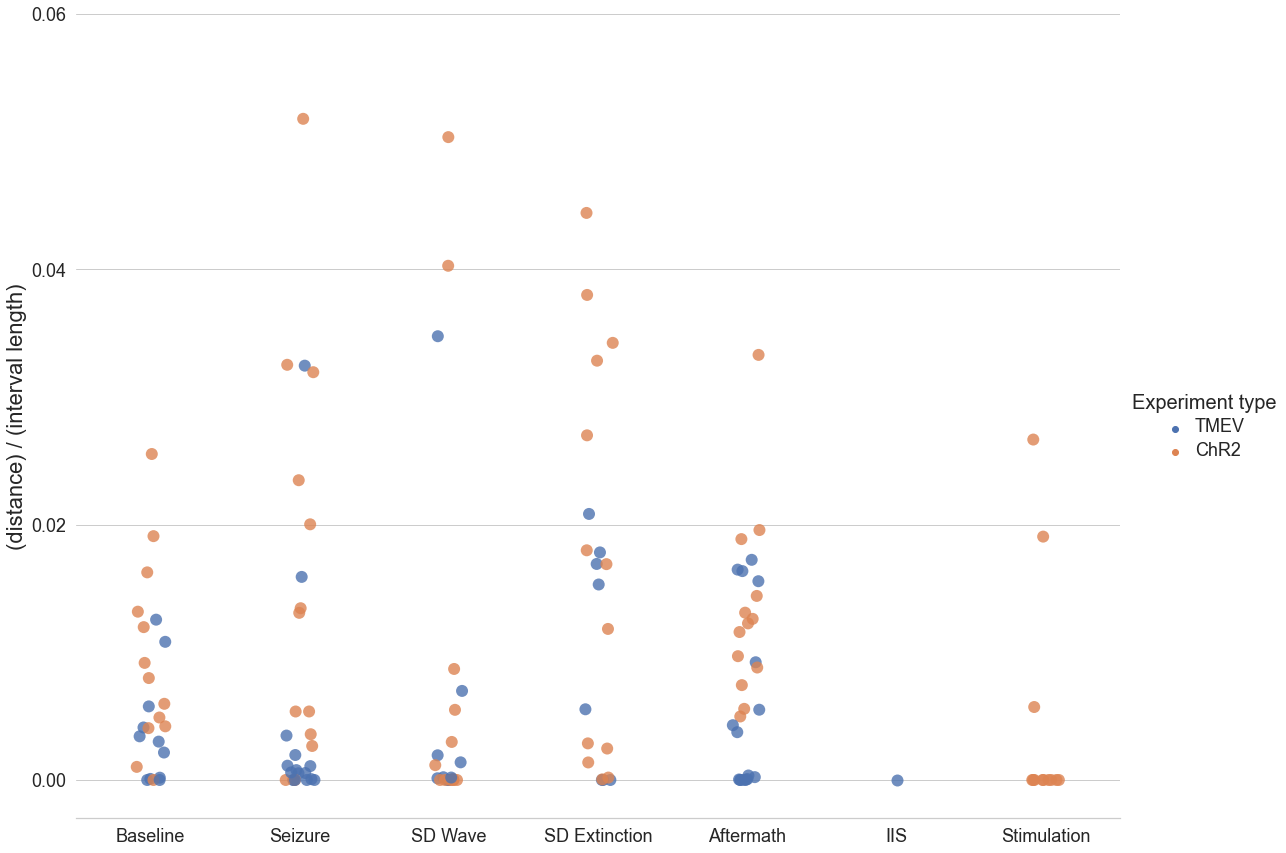

In [39]:
sns.set_theme(style="whitegrid")
#sns.set(rc={'figure.figsize':(20.7,8.27)})

# use standard error or standard deviation for uncertainty/spread, or confidence interval or percentile interval
# se/sd/ci/pi
# see https://seaborn.pydata.org/tutorial/error_bars.html
g = sns.catplot(
    data=df_sz_res, kind="strip",
    x="interval_type_renamed", y="dist_norm", hue="experiment_type_renamed",
    errorbar=("pi", 50), alpha=0.8, height=12, aspect=1.3, size=12
);
g.despine(left=True)
g.set_axis_labels("", "(distance) / (interval length)", fontsize=22)
g.set_xticklabels(["Baseline", "Seizure", "SD Wave", "SD Extinction", "Aftermath", "IIS", "Stimulation"], fontsize=18)
g.set_yticklabels(fontsize=18)
g._legend.set_title("Experiment type")
plt.setp(g._legend.get_title(), fontsize=20);
plt.setp(g._legend.get_texts(),  fontsize=18);
g.set(ylim=(-0.003,0.06));

In [40]:
len(df_sz_res[(df_sz_res["interval_type_renamed"] == "baseline") & (df_sz_res["experiment_type"] == "tmev")])

11

# Compare ChR2 SD vs SZSD running statistics

In [41]:
# take only videos with seizure
df_stim = df_seg_complete.groupby("nd2").filter(lambda group: "stimulation" in group["interval_type"].unique())

In [42]:
# change labels of segments that start the video until seizure as "baseline"
df_stim.loc[(df_stim["interval_type"] == "normal") & (df_stim["frame_begin"] == 1.0), "interval_type"] = "baseline"
# assuming one seizure per video, and that there is no "normal" labeling between "abnormal" events like SZ and SD, 
#   change label to aftermath
# TODO: change this to frame_end == len(recording)? i.e. last part in video?
df_stim.loc[(df_stim["interval_type"] == "normal") & (df_stim["frame_begin"] != 1.0), "interval_type"] = "aftermath"  # second criterion is not even necessary anymore...

In [43]:
stim_vids = df_stim["nd2"].unique()
df_stim_grouping = df_grouping_complete[df_grouping_complete["nd2"].isin(stim_vids)]

In [44]:
len(df_stim_grouping["nd2"]) == len(df_stim_grouping["nd2"].unique())

True

In [45]:
# TODO: integrate this in sz for loop for faster re-run of notebook

In [80]:
ses_segments

,nd2,interval_type,frame_begin,frame_end
55,T452_ChR2_CA1_980_d4_561_5s002.nd2,baseline,1,4572
56,T452_ChR2_CA1_980_d4_561_5s002.nd2,stimulation,4573,4649
57,T452_ChR2_CA1_980_d4_561_5s002.nd2,aftermath,4650,13483


In [85]:
# TODO: rename row to row_grouping, row2 to row_segment

stim_segments_speed_dict = dict()
stim_segments_dist_dict = dict()
stim_segments_totdist_dict = dict()
stim_segments_rounds_dict = dict()
stim_segments_tsscn_dict = dict()
stim_segments_running_dict = dict()

df_stim_res_cols = {"mouse_id": [], "experiment_type": [], "interval_type": [], "distance": [], "d_frames": [], "dt": [], "uid": []}

# for each recording in category, create session, 
# perform labview cut to scanner timeframe, 
# then extract relevant frame movement data
# results appended to segments_dict entries.
# segments_dict should contain, for each key (type of interval) all the corresponding data from all videos
for index, row in df_stim_grouping.iterrows():
    labview_fpath = os.path.join(row["folder"], row["labview"])
    nikmeta_fpath = os.path.join(row["folder"], row["nikon_meta"])
    
    ses = tps.TwoPhotonSession(nd2_timestamps_path=nikmeta_fpath, labview_path=labview_fpath, matlab_2p_folder=matlab_2p_folder)
    ses.infer_labview_timestamps()
    ses._open_data()  # TODO: implement a better way than using "private" function
    ses_segments = df_stim[df_stim["nd2"]==row["nd2"]]  # get all segments from the same file
    for index2, row2 in ses_segments.iterrows():
        uid = uuid.uuid1()  # unique ID of segment, for matching segment labview data with dataframe row
        t0 = int(row2["frame_begin"] - 1)  # correct 1-indexing to 0-indexing, convert to int
        t1 = int(row2["frame_end"])  # list[a:b] returns elements a to (b-1), so no need to subtract here
        
        # Check if dictionary entries exist
        #if row2["interval_type"] not in stim_segments_speed_dict.keys():
        #    stim_segments_speed_dict[row2["interval_type"]] = []
        #if row2["interval_type"] not in stim_segments_dist_dict.keys():   
        #    stim_segments_dist_dict[row2["interval_type"]] = []
        #if row2["interval_type"] not in stim_segments_totdist_dict.keys():     
        #    stim_segments_totdist_dict[row2["interval_type"]] = []
        #if row2["interval_type"] not in stim_segments_rounds_dict.keys():    
        #    stim_segments_rounds_dict[row2["interval_type"]] = []
        #if row2["interval_type"] not in stim_segments_tsscn_dict.keys():    
        #    stim_segments_tsscn_dict[row2["interval_type"]] = []
        #if row2["interval_type"] not in stim_segments_running_dict.keys():    
        #    stim_segments_running_dict[row2["interval_type"]] = []
        
        # append to dictionaries and nd2 list
        stim_segments_speed_dict[uid.int] = deepcopy(ses.belt_scn_dict["speed"][t0:t1])
        stim_segments_dist_dict[uid.int] = deepcopy(ses.belt_scn_dict["distance"][t0:t1])
        stim_segments_totdist_dict[uid.int] = deepcopy(ses.belt_scn_dict["totdist"][t0:t1])
        stim_segments_rounds_dict[uid.int] = deepcopy(ses.belt_scn_dict["rounds"][t0:t1])
        stim_segments_tsscn_dict[uid.int] = deepcopy(ses.belt_scn_dict["tsscn"][t0:t1])
        stim_segments_running_dict[uid.int] = deepcopy(ses.belt_scn_dict["running"][t0:t1])
        
        # append to dataframe columns
        df_stim_res_cols["mouse_id"].append(row["mouse_id"])
        df_stim_res_cols["experiment_type"].append(row["experiment_type"])
        df_stim_res_cols["interval_type"].append(row2["interval_type"])
        df_stim_res_cols["distance"].append(ses.belt_scn_dict["totdist"][t1-1] - ses.belt_scn_dict["totdist"][t0])  # t1 is 1-indexed, t0 0-indexed, see above
        df_stim_res_cols["d_frames"].append(t1 - 1 - t0)  # t1 is 1-indexed, t0 0-indexed, see above
        # dt: in ms
        df_stim_res_cols["dt"].append(ses.belt_scn_dict["tsscn"][t1-1] - ses.belt_scn_dict["tsscn"][t0]) # t1 is 1-indexed, t0 0-indexed, see above
        df_stim_res_cols["uid"].append(uid.int)

Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_2021_11_29\T370.291121.1452time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_2021_11_29
	T370.291121.1452
	T370.291121.1452_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_2021_11_29\T370.291121.1509time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_2021_11_29
	T370.291121.1509
	T370.291121.1509_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_2021_11_29\T370.291121.1603time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_2021_11_29
	T370.291121.1603
	T370.291121.1603_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_ChR2_d9\T370_ChR2_d9.150721.1455time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:


Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_ChR2_LR_d1\T370_ChR2_LR_d1.111121.1658time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_ChR2_LR_d1
	T370_ChR2_LR_d1.111121.1658
	T370_ChR2_LR_d1_488_5s_005_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_ChR2_LR_d2\T370.181121.1709time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_ChR2_LR_d2
	T370.181121.1709
	T370.181121.1709_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_ChR2_LR_d3\T370.191121.1521time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_ChR2_LR_d3
	T370.191121.1521
	T370.191121.1521_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T370_ChR2\T370_ChR2_LR_d3\T370.191121.1410time.txt
Calling Matlab-2p beltProcessPipeli

Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_11_05
	T386.051121.1409
	T386.051121.1409_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_11_25\T386.251121.1641time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_11_25
	T386.251121.1641
	T386.251121.1641_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_11_25\T386.251121.1723time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_11_25
	T386.251121.1723
	T386.251121.1723_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_11_25\T386.251121.1816time.txt
Calling Matlab-2p beltProcessPipelineExpProps with arguments:
	Y:\AG-Wenzel\Group\ChRod2\T386_ChR2\2021_11_25
	T386.251121.1816
	T386.251121.1816_nik
Inferred labview timestamps file path:
	Y:\AG-Wenzel\Group\ChRod

In [86]:
# create df from dict:
df_stim_res = pd.DataFrame.from_dict(df_stim_res_cols)

In [87]:
df_stim_res.head()

,mouse_id,experiment_type,interval_type,distance,d_frames,dt,uid
0,T370,chr2_ctl,baseline,1805.0,4571,308743.000,231603473132827658435333136659101751165
1,T370,chr2_ctl,stimulation,0.0,38,2566.900,231604261769957325420139835519963469693
2,T370,chr2_ctl,aftermath,3691.0,8871,599180.700,231604261849185487936855257210703812477
3,T370,chr2_szsd,baseline,150.0,4571,300047.253,245886597445906985022513610378884650877
4,T370,chr2_szsd,stimulation,16.0,39,2560.005,245886597525135147533497920068819326845


In [88]:
# normalize distance by the interval length 
# also take absolute value; especially during shorter intervals, mice might step backwards a few times and that's it 
df_stim_res["dist_norm"] = abs(df_stim_res["distance"]/df_stim_res["dt"])  

In [89]:
df_stim_res["dist_norm"].describe()

count    304.000000
mean       0.021908
std        0.034681
min        0.000000
25%        0.002854
50%        0.009674
75%        0.022961
max        0.242050
Name: dist_norm, dtype: float64

In [90]:
df_stim_res.head()

,mouse_id,experiment_type,interval_type,distance,d_frames,dt,uid,dist_norm
0,T370,chr2_ctl,baseline,1805.0,4571,308743.000,231603473132827658435333136659101751165,0.005846
1,T370,chr2_ctl,stimulation,0.0,38,2566.900,231604261769957325420139835519963469693,0.000000
2,T370,chr2_ctl,aftermath,3691.0,8871,599180.700,231604261849185487936855257210703812477,0.006160
3,T370,chr2_szsd,baseline,150.0,4571,300047.253,245886597445906985022513610378884650877,0.000500
4,T370,chr2_szsd,stimulation,16.0,39,2560.005,245886597525135147533497920068819326845,0.006250


In [91]:
df_stim_res["experiment_type"].unique()

array(['chr2_ctl', 'chr2_szsd', 'chr2_sd'], dtype=object)

In [92]:
df_stim_res["experiment_type_renamed"] = df_stim_res["experiment_type"].replace({"chr2_ctl": "Control", "chr2_szsd": "Sz+SD", "chr2_sd": "SD"})

In [93]:
df_stim_res.head()

,mouse_id,experiment_type,interval_type,distance,d_frames,dt,uid,dist_norm,experiment_type_renamed
0,T370,chr2_ctl,baseline,1805.0,4571,308743.000,231603473132827658435333136659101751165,0.005846,Control
1,T370,chr2_ctl,stimulation,0.0,38,2566.900,231604261769957325420139835519963469693,0.000000,Control
2,T370,chr2_ctl,aftermath,3691.0,8871,599180.700,231604261849185487936855257210703812477,0.006160,Control
3,T370,chr2_szsd,baseline,150.0,4571,300047.253,245886597445906985022513610378884650877,0.000500,Sz+SD
4,T370,chr2_szsd,stimulation,16.0,39,2560.005,245886597525135147533497920068819326845,0.006250,Sz+SD


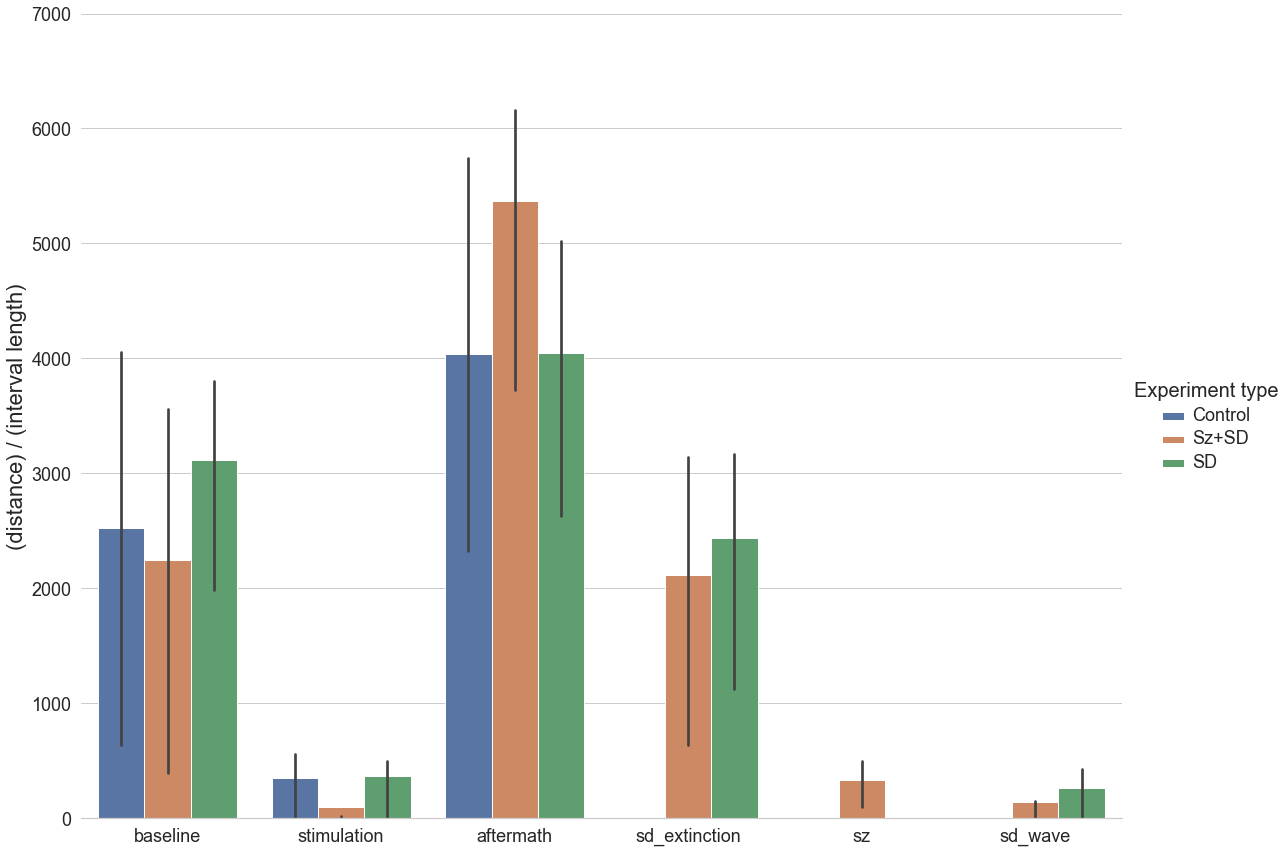

In [94]:
sns.set_theme(style="whitegrid")
# use standard error or standard deviation for uncertainty/spread, or confidence interval or percentile interval
# se/sd/ci/pi
# see https://seaborn.pydata.org/tutorial/error_bars.html

g = sns.catplot(
    data=df_stim_res, kind="bar",
    x="interval_type", y="distance", hue="experiment_type_renamed",
    errorbar=("pi", 50), height=12, aspect=1.3 #, alpha=0.6,
)

#g = sns.catplot(
#    data=df_stim_res, kind="box",
#    x="interval_type", y="dist_norm", hue="experiment_type",
#    errorbar="se", palette="dark", height=10, aspect=1.3
#)
#sns.stripplot(
#    data=df_stim_res,
#    x="interval_type", y="dist_norm", hue="experiment_type", size=12,
#)

g.despine(left=True)
g.set_axis_labels("", "(distance) / (interval length)", fontsize=22)
#g.set_xticklabels(["Baseline", "Stimulation", "Aftermath", "SD extinciton", "Seizure", "SD Wave",], fontsize=18)
g.set_xticklabels(fontsize=18)
g.set_yticklabels(fontsize=18)
g._legend.set_title("Experiment type")
plt.setp(g._legend.get_title(), fontsize=20);
plt.setp(g._legend.get_texts(),  fontsize=18);

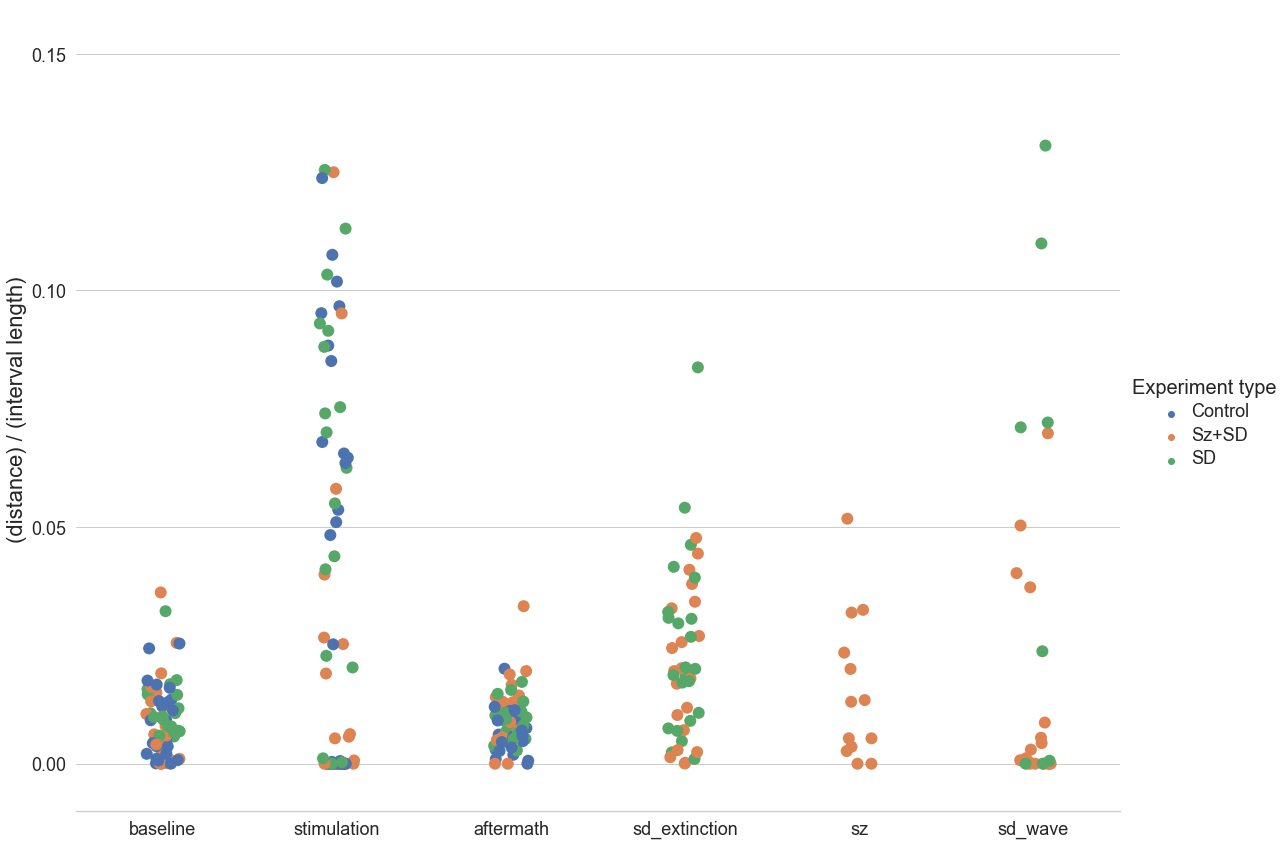

In [95]:
g2 = sns.catplot(
    data=df_stim_res, kind="strip",
    x="interval_type", y="dist_norm", hue="experiment_type_renamed", height=12, aspect=1.3, size=12
)
g2.despine(left=True)
g2.set_axis_labels("", "(distance) / (interval length)", fontsize=22)
#g2.set_xticklabels(["Baseline", "Stimulation", "Aftermath", "Seizure", "SD Wave", "SD Extinction"], fontsize=18)
g2.set_xticklabels( fontsize=18)
g2.set_yticklabels(fontsize=18)
g2._legend.set_title("Experiment type")
plt.setp(g2._legend.get_title(), fontsize=20);
plt.setp(g2._legend.get_texts(),  fontsize=18);
g2.set(ylim=(-0.01,0.16));

# Plot individual sessions over each other

In [117]:
df_stim_res

,mouse_id,experiment_type,interval_type,distance,d_frames,dt,uid,dist_norm,experiment_type_renamed
0,T370,chr2_ctl,baseline,1805.000000,4571,308743.000,231603473132827658435333136659101751165,0.005846,Control
1,T370,chr2_ctl,stimulation,0.000000,38,2566.900,231604261769957325420139835519963469693,0.000000,Control
2,T370,chr2_ctl,aftermath,3691.000000,8871,599180.700,231604261849185487936855257210703812477,0.006160,Control
3,T370,chr2_szsd,baseline,150.000000,4571,300047.253,245886597445906985022513610378884650877,0.000500,Sz+SD
4,T370,chr2_szsd,stimulation,16.000000,39,2560.005,245886597525135147533497920068819326845,0.006250,Sz+SD
...,...,...,...,...,...,...,...,...,...
299,T452,chr2_ctl,stimulation,129.459148,76,5132.900,212216067477692177416369745068232775549,0.025221,Control
300,T452,chr2_ctl,aftermath,6756.830840,8832,596548.000,212216067556920339932959065969406744445,0.011327,Control
301,T452,chr2_ctl,baseline,7543.365659,4571,309624.797,227150742094631472440662520690048997245,0.024363,Control
302,T452,chr2_ctl,stimulation,254.634740,76,4988.728,227150742173859634952523624932437366653,0.051042,Control


In [118]:
#  make a plot of individual movement 
g_exptype_itype = df_stim_res.groupby(["experiment_type", "interval_type"])

In [131]:
bl_ctl = g_exptype_itype.get_group(("chr2_ctl", "baseline"))["uid"]
bl_sd  = g_exptype_itype.get_group(("chr2_sd", "baseline"))["uid"]
bl_szsd= g_exptype_itype.get_group(("chr2_szsd","baseline"))["uid"]

In [166]:
bl_ctl_tsscn = dict()
for uid_ctl in bl_ctl:
    bl_ctl_tsscn[uid_ctl] = stim_segments_tsscn_dict[uid_ctl]

In [169]:
t_min =  9000000000  # will be first recorded time point in subset of data
t_max = -9000000000  # latest time point in subset of data
for key, value in bl_ctl_tsscn.items():
    if min(value) < t_min:
        t_min = min(value)
    if max(value) > t_max:
        t_max = max(value)

In [197]:
bl_ctl = sorted(bl_ctl, key= lambda uid: sum(stim_segments_running_dict[uid]), reverse=True)

In [214]:
# match recordings in time by shifting so that last data point has the same time in all cases
stim_segments_t_matched_dict = dict()
for uid in bl_ctl:
    dt = t_max - stim_segments_tsscn_dict[uid][-1]
    stim_segments_t_matched_dict[uid] = dt + deepcopy(stim_segments_tsscn_dict[uid])

In [210]:
stim_segments_tsscn_dict[bl_ctl[0]] 

array([     0. ,     67.5,    135.1, ..., 308611.6, 308679.2, 308746.8])

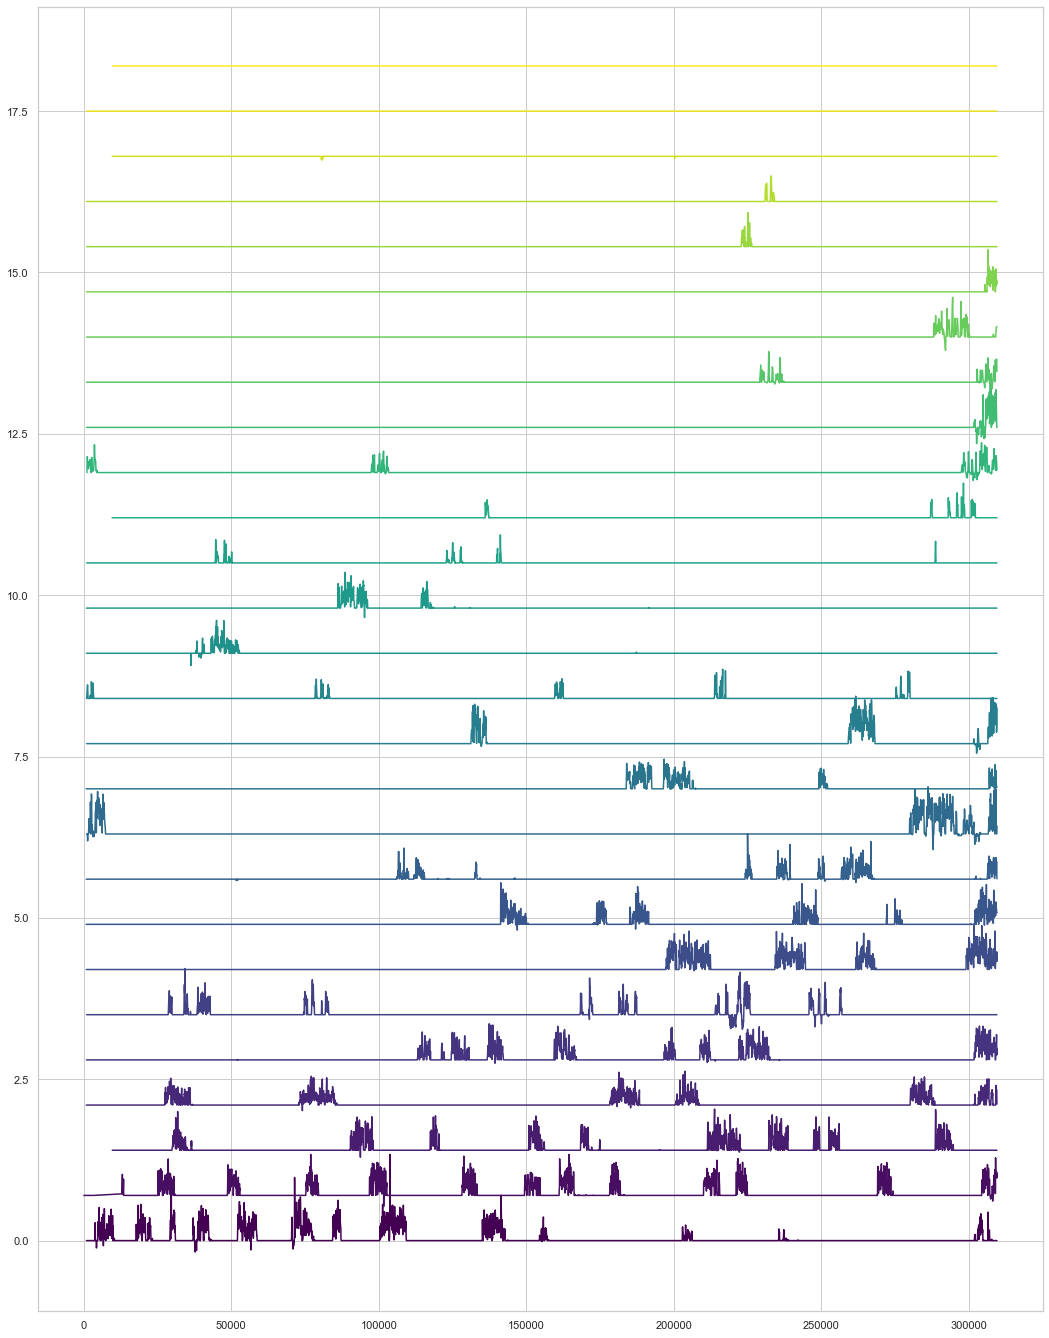

In [215]:
cmap = cm.get_cmap('viridis', len(bl_ctl))
fig = plt.figure(figsize=(18,24))
for i_session, ctl_session in enumerate(bl_ctl):
    plt.plot(stim_segments_t_matched_dict[ctl_session],i_session*0.7 + stim_segments_speed_dict[ctl_session], color=cmap.colors[i_session])
plt.show()

In [ ]:
# TODO: create a UID for individual recordings (to match various segments in the dictionaries).
# TODO: plot movement starting with stimulation. How long it should be plotted? Match color map with baseline,
#       sort by movement amount 

In [ ]:
cmap = cm.get_cmap('viridis', len(bl_ctl))
fig = plt.figure(figsize=(18,18))
for i_session, ctl_session in enumerate(bl_ctl):
    plt.plot(i_session*0.5 + stim_segments_speed_dict[ctl_session], color=cmap.colors[i_session])
plt.show()

In [ ]:
df_stim_res.head()

In [ ]:
len(df_stim_res[(df_stim_res["experiment_type"] == "chr2_sd") & (df_stim_res["interval_type"] == "baseline")])

# TMEV running over days

# Unorganized

In [ ]:
# keys of belt_scn_dict: 'tsscn', 'rounds', 'speed', 'distance', 'totdist', 'running'

In [ ]:
# think about data to quantify (integrated velocity/distance per interval? divided by interval length)
# maybe need nd2 to extract mean, check if zones correspond to imaging data

In [ ]:
res_dict = dict()
for interval_type in segments_totdist_dict.keys():
    res_dict[interval_type] = []
    for dist_lis in segments_totdist_dict[interval_type]:
        assert dist_lis[-1] >= 0
        assert dist_lis[0] >= 0
        totdist_interval = (dist_lis[-1] - dist_lis[0])/len(dist_lis)
        res_dict[interval_type].append(totdist_interval)

In [ ]:
res_dict.keys()

In [ ]:
# TODO: get results also for control animal, make a dataframe including all these 
# (columns: 
#    tmev/chr2/ctl (exp_type?), 
#    interval_type ('baseline', 'sz', 'sd_wave', 'sd_extinction', 'normal'),
#    total distance,
#    etc. (other data like dist, for comparison. But I think totdist is the one I need)

# Then plot as seaborn catplot (grouped barplot)

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=a, kind="bar",
    x="", y="body_mass_g", hue="sex",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")